# CitiBike Type Prediction

## Introduction to Problem & Data

#### Problem Statement:

CitiBike’s bike-sharing data offers valuable insights into how users use its bike-sharing service, particularly their choices between classic and electric bikes. The goal of this project is to develop a predictive model that can identify which type of bike a user is likely to choose based on trip characteristics, such as ride duration, ride distance, time of day, and user type (member or non-member). By leveraging these features, this project aims to uncover patterns that influence bike selection and can provide actionable insights for CitiBike to improve its operations. Successfully developing a classification model could enable CitiBike to improve management and operational efficiency. CitiBike can optimize bike distribution and make improvements on its membership offerings. Additionally, understanding these trends can enhance user satisfaction by reducing wait times and better meet customer bike preferences. Furthermore, these insights gained may help inform future strategies for bike-sharing systems in other cities.


#### Dataset Description:

Data for this project is sourced from CitiBike’s publicly available system data, accessed in csv format from their website. It provides comprehensive information about bike-sharing trips, including ride type, ride duration, distance, start and end locations (coordinates), and user type. The dataset will require some cleaning since the original csv contains about 1 million lines and some null values. There may be challenges in building an accurate classification model due to the range of factors not in the dataset influencing bike type selection, such as user preferences and trip characteristics. However, I believe that certain predictive variables provided in the data, like ride duration, distance, member type, and time of day, will help determine the type of bike chosen. 


#### Data Pre-Processing & Preliminary Examination:

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
# This is a one-time run I did to cut down the size of the dataset. The original is 1 million lines
# Load original data, take 10000 random rows and save down as new csv for project to work with
'''
df = pd.read_csv('202305-citibike-tripdata_1.csv')
sample_df = df.sample(n=10000, random_state=10)
sample_df.to_csv('202305-citibike-tripdata_1_sampled.csv', index=False)
'''

"\ndf = pd.read_csv('202305-citibike-tripdata_1.csv')\nsample_df = df.sample(n=10000, random_state=10)\nsample_df.to_csv('202305-citibike-tripdata_1_sampled.csv', index=False)\n"

In [48]:
# Start Here

# Load dataset
df = pd.read_csv('202305-citibike-tripdata_1_sampled.csv')
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C12843EC95E5C691,classic_bike,2023-05-08 19:31:49.131,2023-05-08 19:39:03.486,W 16 St & The High Line,6233.05,E 16 St & 5 Ave,6022.04,40.743349,-74.006818,40.737262,-73.992390,member
1,C80D9923FA7AFB94,electric_bike,2023-05-02 17:12:52.102,2023-05-02 17:14:03.851,5 Ave & E 87 St,7323.09,5 Ave & E 87 St,7323.09,40.782323,-73.959875,40.782323,-73.959875,member
2,393A4F003972434C,classic_bike,2023-05-22 23:00:49.204,2023-05-22 23:06:00.554,W 15 St & 6 Ave,5989.02,Washington St & Gansevoort St,6039.06,40.738046,-73.996430,40.739323,-74.008119,member
3,66E9B11A01A18958,electric_bike,2023-05-08 15:31:04.387,2023-05-08 16:13:58.040,Walton Ave & E 176 St,8362.02,Grand Concourse & E 156 St,7984.04,40.848452,-73.909654,40.823429,-73.924689,member
4,D9534B4DA6192C49,electric_bike,2023-05-19 11:41:52.108,2023-05-19 11:56:28.154,Schermerhorn St & Court St,4565.07,Allen St & Rivington St,5414.06,40.691036,-73.992011,40.720196,-73.989978,member


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ride_id             10000 non-null  object 
 1   rideable_type       10000 non-null  object 
 2   started_at          10000 non-null  object 
 3   ended_at            10000 non-null  object 
 4   start_station_name  9991 non-null   object 
 5   start_station_id    9991 non-null   float64
 6   end_station_name    9922 non-null   object 
 7   end_station_id      9922 non-null   object 
 8   start_lat           10000 non-null  float64
 9   start_lng           10000 non-null  float64
 10  end_lat             9974 non-null   float64
 11  end_lng             9974 non-null   float64
 12  member_casual       10000 non-null  object 
dtypes: float64(5), object(8)
memory usage: 1015.8+ KB


In [50]:
# Create a column for ride duration by subtracting started_at from ended_at
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['ride_minutes'] = (df['ended_at'] - df['started_at']
                      ).dt.total_seconds() / 60

In [51]:
# Create a column for ride time of day by categorizing started_at
def categorize_time(hour):
    if 0 <= hour < 6:
        return 'night'
    elif 6 <= hour < 10:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'


df['tod'] = df['started_at'].dt.hour.apply(categorize_time)

In [52]:
!pip install geopy

In [53]:
# Create a column for ride distance in miles using start/end lat/long
from geopy.distance import geodesic

df = df.dropna()


def calculate_distance(row):
    start_coords = (row['start_lat'], row['start_lng'])
    end_coords = (row['end_lat'], row['end_lng'])
    return geodesic(start_coords, end_coords).miles


df['ride_miles'] = df.apply(calculate_distance, axis=1)
df = df[df['ride_miles'] > 0]

In [54]:
# Drop columns we will not be using
keep = ['rideable_type', 'member_casual', 'ride_minutes', 'ride_miles', 'tod']
df = df.drop(columns=[col for col in df.columns if col not in keep])
df.head()

,rideable_type,member_casual,ride_minutes,tod,ride_miles
0,classic_bike,member,7.239250,evening,0.865933
2,classic_bike,member,5.189167,evening,0.619814
3,electric_bike,member,42.894217,afternoon,1.897988
4,electric_bike,member,14.600767,evening,2.014889
5,classic_bike,member,8.864317,afternoon,0.964408


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9707 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rideable_type  9707 non-null   object 
 1   member_casual  9707 non-null   object 
 2   ride_minutes   9707 non-null   float64
 3   tod            9707 non-null   object 
 4   ride_miles     9707 non-null   float64
dtypes: float64(2), object(3)
memory usage: 455.0+ KB


In [56]:
df['ride_minutes'].describe()

count    9707.000000
mean       14.743512
std        24.012335
min         1.006117
25%         5.553658
50%        10.001100
75%        17.923467
max       976.924817
Name: ride_minutes, dtype: float64

In [57]:
# There seem to be some outliers in ride_minutes so let's cap it at 3hrs
df = df[df['ride_minutes'] < 180]

In [58]:
df['ride_minutes'].describe()

count    9691.000000
mean       14.068484
std        13.545929
min         1.006117
25%         5.547000
50%         9.992083
75%        17.834633
max       174.071400
Name: ride_minutes, dtype: float64

In [59]:
df['ride_miles'].describe()

count    9691.000000
mean        1.224770
std         1.091133
min         0.000750
25%         0.503846
50%         0.903987
75%         1.590723
max        12.108184
Name: ride_miles, dtype: float64

In [60]:
df['member_casual'].value_counts()

member_casual
member    7796
casual    1895
Name: count, dtype: int64

In [61]:
df['tod'].value_counts()

tod
afternoon    3982
evening      3751
morning      1581
night         377
Name: count, dtype: int64

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9691 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rideable_type  9691 non-null   object 
 1   member_casual  9691 non-null   object 
 2   ride_minutes   9691 non-null   float64
 3   tod            9691 non-null   object 
 4   ride_miles     9691 non-null   float64
dtypes: float64(2), object(3)
memory usage: 454.3+ KB


The revised dataset that I'll be working with contains 9691 data points on CitiBike rides in May 2023. The rides range from 1 minute to 174 minutes, and are on average 1.22 miles long.

## Exploratory Data Analysis

In [63]:
df.head()

,rideable_type,member_casual,ride_minutes,tod,ride_miles
0,classic_bike,member,7.239250,evening,0.865933
2,classic_bike,member,5.189167,evening,0.619814
3,electric_bike,member,42.894217,afternoon,1.897988
4,electric_bike,member,14.600767,evening,2.014889
5,classic_bike,member,8.864317,afternoon,0.964408


#### Descriptive Statistics

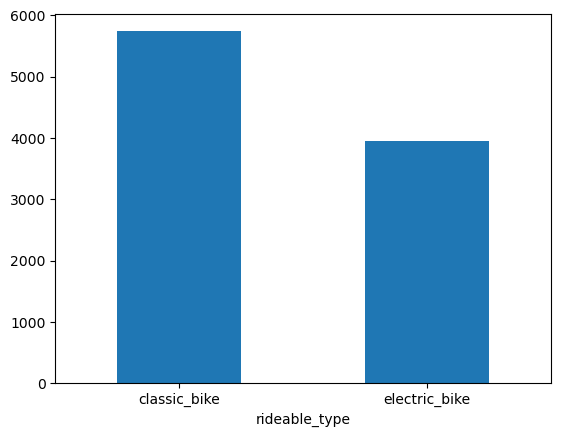

In [64]:
df['rideable_type'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

There are more classic bikes in this dataset (even after randomly sampled), potentially because of the higher price of using ebikes.

#### Initial Visualizations

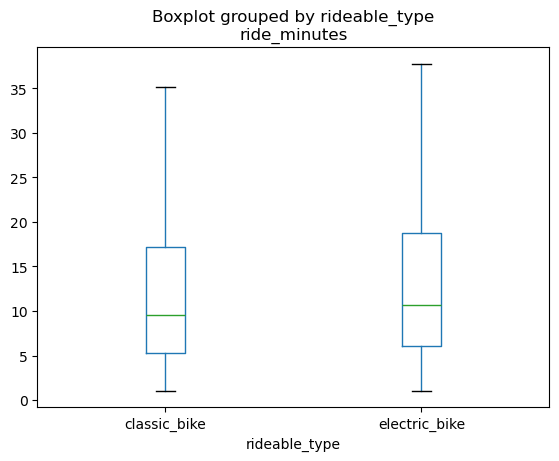

In [65]:
# Plot ride_minutes grouped by rideable_type
df.boxplot(column='ride_minutes', by='rideable_type',
           grid=False, showfliers=False)
plt.show()

This boxplot shows the distribution of ride minutes grouped by bike type. Both bike types have similar ranges for ride durations, but the median ride time for ebikes is slightly higher than for classic bikes. Additionally, ebikes have a slightly wider IQR for ride times.








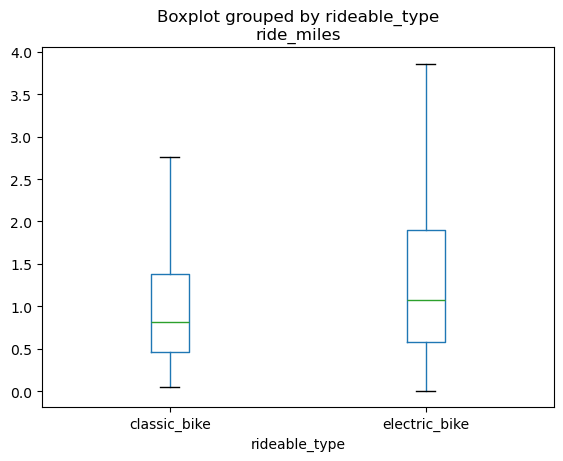

In [66]:
# Plot ride_miles grouped by rideable_type
df.boxplot(column='ride_miles', by='rideable_type',
           grid=False, showfliers=False)
plt.show()

Electric bikes generally have longer rides (both in terms of median and range), which might suggest they are chosen for longer distances. Classic bikes have shorter and more consistent ride distances.

0    60.580475
1    39.419525
2    58.889174
3    41.110826
Name: percent, dtype: float64

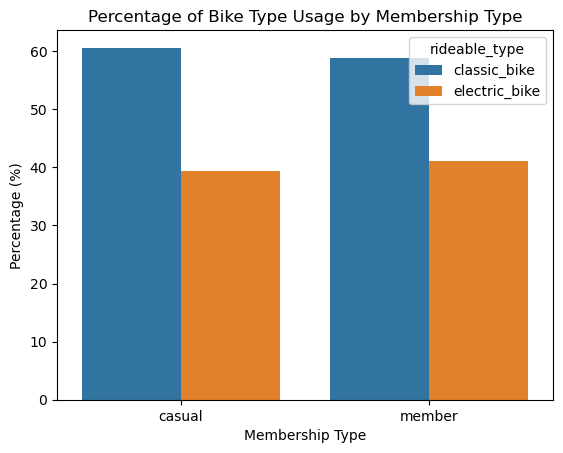

In [67]:
# Plot percentage of bike type within each membership type
member_bike_counts = df.groupby(
    ["member_casual", "rideable_type"]).size().reset_index(name="count")
total_counts = member_bike_counts.groupby(
    "member_casual")["count"].transform("sum")
member_bike_counts["percent"] = 100 * \
    member_bike_counts["count"] / total_counts
display(member_bike_counts["percent"])

sns.barplot(data=member_bike_counts, x="member_casual",
            y="percent", hue="rideable_type")
plt.title("Percentage of Bike Type Usage by Membership Type")
plt.ylabel("Percentage (%)")
plt.xlabel("Membership Type")
plt.show()

The chart displays the percentage of bike types used within each membership category. Among casual users, 60.6% use classic bikes, while 39.4% prefer ebikes. For members, the distribution is closer, with 58.9% using classic bikes and 41.1% using ebikes. This indicates that while both user groups show a preference for classic bikes, members have a slightly higher tendency to use ebikes compared to casual users.

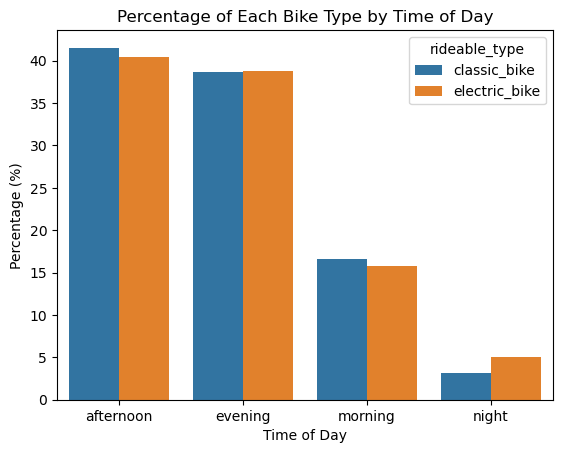

In [68]:
# Plot percentage of bike type within each time of day
tod_type_counts = df.groupby(
    ["rideable_type", "tod"]).size().reset_index(name="count")
total_counts = tod_type_counts.groupby(
    "rideable_type")["count"].transform("sum")
tod_type_counts["percent"] = 100 * tod_type_counts["count"] / total_counts

sns.barplot(data=tod_type_counts, x="tod", y="percent", hue="rideable_type")
plt.title("Percentage of Each Bike Type by Time of Day")
plt.ylabel("Percentage (%)")
plt.xlabel("Time of Day")
plt.show()

The distribution between the bike types in the evening is about even. There is slight preference for classic bikes in the morning and afternoons, and vice versa at night. We also see that most rides are taken in the afternoon and evening, while far fewer are in the morning and night.

To summarize, it seems like miles ridden may provide us with the most information on predicting which bike type is chosen. Time of day may also provide some insights, while distance and membership type may provide the least information.

## Modeling & Interpretations

To predict type of bike, I am planning on using multiple different classification models to see which performs the best in predicting the bike type chosen. For each of these models, I will use a 80-20 train-test split.

In [69]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

#### Logistic Regression Model

Starting with the Logistic Regression Model, I chose this model as a "baseline" since it is a simple and reliable method for classification problems. It helps show how each feature influences the prediction, making it easy to understand the results. Logistic regression works well when the data is straightforward and there are clear relationships between variables and the target.

In [70]:
# Create X and Y
X = df.iloc[:, 1:]
y = df['rideable_type']

# Split into train and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11)

# Define categorical and numerical columns
cat_cols = ['member_casual', 'tod']
num_cols = ['ride_minutes', 'ride_miles']

# Make column transformer and encode
ohe = OneHotEncoder(drop='first', sparse_output=False)
sscaler = StandardScaler()
transformer = make_column_transformer(
    (ohe, cat_cols), (sscaler, num_cols), remainder='passthrough')

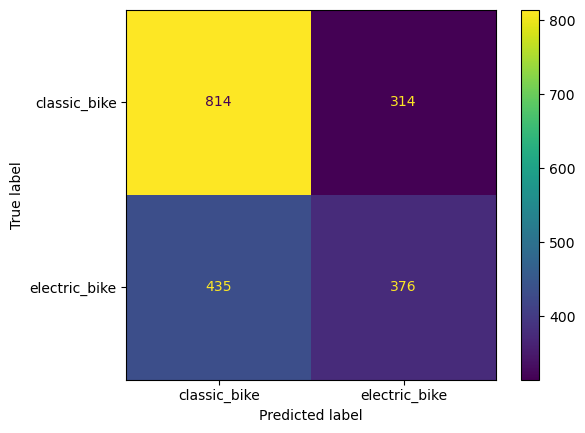

In [71]:
# Create pipeline
lgr = LogisticRegression(class_weight='balanced')
lgr_pipe = Pipeline([('transform', transformer), ('model', lgr)])

# Fit pipeline
lgr_pipe.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(lgr_pipe, X_test, y_test)

In [72]:
print(f'Train Score: {lgr_pipe.score(X_train, y_train)}')
print(f'Test Score: {lgr_pipe.score(X_test, y_test)}')

y_pred = lgr_pipe.predict(X_test)

# Precision scores
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision Score: {precision}")

# Perform cross-validation
cv_scores = cross_val_score(
    lgr_pipe, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

# Classification report
classification = classification_report(y_test, y_pred)
print(f"Classification Report:\n{classification}")

Train Score: 0.6029411764705882
Test Score: 0.6137184115523465
Precision Score: 0.6070541233907966
Cross-Validation Scores: [0.59445519 0.61637653 0.60709677 0.60064516 0.59612903]
Mean Cross-Validation Accuracy: 0.602940537842391
Classification Report:
               precision    recall  f1-score   support

 classic_bike       0.65      0.72      0.68      1128
electric_bike       0.54      0.46      0.50       811

     accuracy                           0.61      1939
    macro avg       0.60      0.59      0.59      1939
 weighted avg       0.61      0.61      0.61      1939



This output shows the performance of a logistic regression model for predicting bike type. The precision and recall results suggest that the model is better at identifying classic bikes compared to electric bikes. The model struggles with correctly classifying electric bikes, as shown by the confusion matrix. There are more electric bikes accidentally classified as classic bikes than those correctly classified, and many fewer vice versa. Overall, the test score is relatively low and we can likely find a more accurate model.

#### KNearest-Neighbors

Next I chose to try the KNearest-Neighbors because it is simple and makes predictions based on the similarity between data points. This makes it easy to understand local patterns in the data. KNN works well when the relationship between the variables and the target may be non-linear, which I believe is the case because the relationships and interactions between variables may be more complex. KNN doesn't rely on a fixed model structure, which allows it to adapt to the dataset and identify patterns.

In [73]:
X = df.iloc[:, 1:]
y = df['rideable_type']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11)

param_grid = {'model__n_neighbors': [5, 10, 15, 20, 25]}

# Define the KNN model
knn = KNeighborsClassifier()

# Create the pipeline
knn_pipe = Pipeline([('transformer', transformer), ('model', knn)])

# Define GridSearchCV
grid = GridSearchCV(estimator=knn_pipe, param_grid=param_grid,
                    cv=5, scoring='accuracy', refit=True)
grid.fit(X_train, y_train)

# Display the best parameters and score
grid.best_params_, grid.best_score_, grid.best_estimator_.score(X_test, y_test)

({'model__n_neighbors': 15}, 0.6842098126078909, 0.666838576585869)

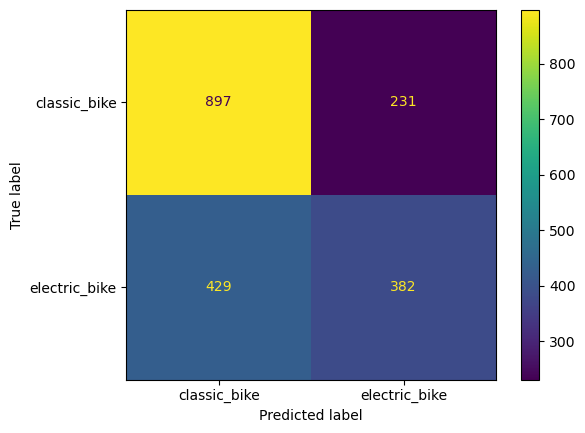

In [74]:
knn2 = KNeighborsClassifier(weights='distance', n_neighbors=15)
knn_pipe2 = Pipeline([('transform', transformer), ('model', knn2)])
knn_pipe2.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(knn_pipe2, X_test, y_test)

In [75]:
print(f'Train Score: {knn_pipe2.score(X_train, y_train)}')
print(f'Test Score: {knn_pipe2.score(X_test, y_test)}')

y_pred = knn_pipe2.predict(X_test)

precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision Score: {precision}")

cv_scores = cross_val_score(
    knn_pipe2, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

classification = classification_report(y_test, y_pred)
print(f"Classification Report:\n{classification}")

Train Score: 1.0
Test Score: 0.6596183599793708
Precision Score: 0.6541750627613074
Cross-Validation Scores: [0.67891683 0.67633785 0.66967742 0.66       0.6683871 ]
Mean Cross-Validation Accuracy: 0.6706638381065286
Classification Report:
               precision    recall  f1-score   support

 classic_bike       0.68      0.80      0.73      1128
electric_bike       0.62      0.47      0.54       811

     accuracy                           0.66      1939
    macro avg       0.65      0.63      0.63      1939
 weighted avg       0.65      0.66      0.65      1939



The testing score in my KNN model reflects better performance than logistic regression likely because of multiple factors, such as how it can adapt better to the structure of the dataset, it an capture non-linear patterns, and also how GridSearchCV fine-tunes parameters to find the most accurate model. However, it still seems to misclassify many of the electric bikes as classic bikes, though to a slightly lesser degree. The confusion matrix shows that it correctly classifies more classic bikes than the logistic regression model does.


#### Decision Tree Model

My next model is a Decision Tree Classifier model. Similar to how KNN works, decision trees also capture non-linear relationships. Unlike with KNN, decision trees may be better with unseen relationships since it does not depend on proximity of data points and are better at splitting the data into groups. This may be good for my bike dataset since it provides clear, interpretable rules that show how features influence my target.

In [76]:
X = df.iloc[:, 1:]
y = df['rideable_type']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11)

param_grid = {'model__max_depth': range(1, 21)}

# Define the tree model
tree = DecisionTreeClassifier(class_weight='balanced')

# Create the pipeline
tree_pipe = Pipeline([('transformer', transformer), ('model', tree)])

# Define GridSearchCV
grid = GridSearchCV(estimator=tree_pipe, param_grid=param_grid,
                    cv=5, scoring='accuracy', refit=True)
grid.fit(X_train, y_train)

# Display the best parameters and score
grid.best_params_, grid.best_score_, grid.best_estimator_.score(X_test, y_test)

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


({'model__max_depth': 7}, 0.6634418585303966, 0.6575554409489428)

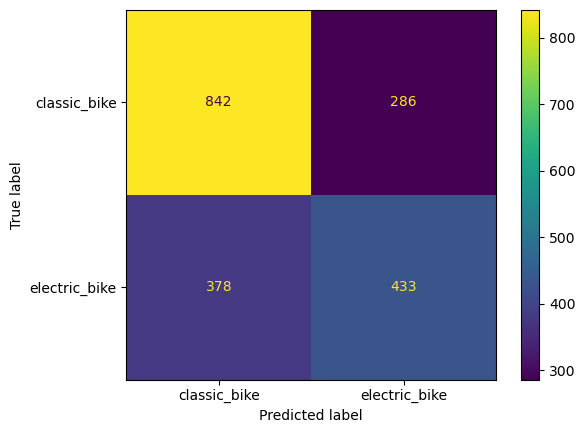

In [77]:
tree2 = DecisionTreeClassifier(max_depth=7, class_weight='balanced')
tree_pipe2 = Pipeline([('transformer', transformer), ('model', tree2)])
tree_pipe2.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(tree_pipe2, X_test, y_test)

In [78]:
print(f'Train Score: {tree_pipe2.score(X_train, y_train)}')
print(f'Test Score: {tree_pipe2.score(X_test, y_test)}')

y_pred = tree_pipe2.predict(X_test)

precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision Score: {precision}")

cv_scores = cross_val_score(
    tree_pipe2, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

classification = classification_report(y_test, y_pred)
print(f"Classification Report:\n{classification}")

Train Score: 0.7127192982456141
Test Score: 0.6575554409489428
Precision Score: 0.6533830050658963
Cross-Validation Scores: [0.66795616 0.65764023 0.65548387 0.66967742 0.66580645]
Mean Cross-Validation Accuracy: 0.6633128262723321
Classification Report:
               precision    recall  f1-score   support

 classic_bike       0.69      0.75      0.72      1128
electric_bike       0.60      0.53      0.57       811

     accuracy                           0.66      1939
    macro avg       0.65      0.64      0.64      1939
 weighted avg       0.65      0.66      0.65      1939



The Decision Tree model has a higher precision score and mean cross-validation accuracy than both the KNN and Logistic Regression models. At a max_depth of 7 (as found through GridSearchCV), this model more correctly predicts electric bikes correctly. However, it seems to perform worse with correctly predicting classic bikes. This may be because the model focuses on optimizing overall precision and accuracy, which can cause it to focus on classifying electric bikes if it is harder to classify. The tree may be more constrained at a max depth of 7 and it cannot fully split the data into smaller, more specific groups that may accurately predict classic bikes.

#### Random Forest Classifier Model

I chose to use a Random Forest Classifier model to potentially handle some class imbalances in my data. Similar to decision trees, random forests can capture non-linear relationships and handle both categorical and numerical data. Unlike a single decision tree, random forests combine multiple trees to reduce overfitting and improve performance on unseen data. This may be good for my bike dataset since it adds robustness to predictions and can capture more complex patterns in the features that may influence bike type chosen.

In [79]:
X = df.iloc[:, 1:]
y = df['rideable_type']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11)

param_grid_rf = {'model__n_estimators': [
    20, 50], 'model__max_depth': [10, 15, 20]}

# Define the Random Forest model
rf = RandomForestClassifier(class_weight='balanced', random_state=11)

# Create the pipeline
rf_pipe = Pipeline([('transformer', transformer), ('model', rf)])

# Define GridSearchCV
grid = GridSearchCV(estimator=rf_pipe, param_grid=param_grid_rf,
                    cv=5, scoring='accuracy', refit=True)
grid.fit(X_train, y_train)

# Display the best parameters and score
grid.best_params_, grid.best_score_, grid.best_estimator_.score(X_test, y_test)

({'model__max_depth': 10, 'model__n_estimators': 50},
 0.6825322268671618,
 0.6689014956162971)

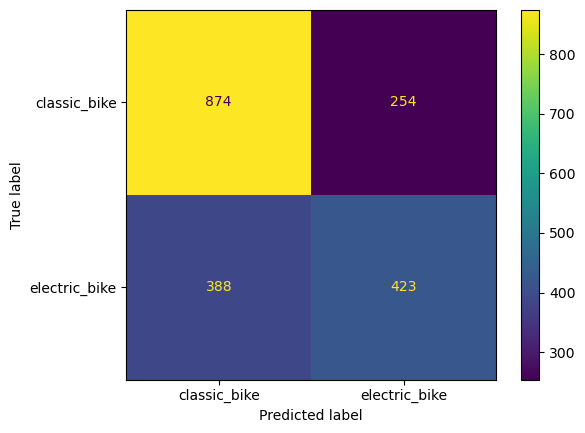

In [80]:
rf2 = RandomForestClassifier(
    class_weight='balanced', random_state=11, max_depth=10, n_estimators=50)
rf_pipe2 = Pipeline([('transformer', transformer), ('model', rf2)])
rf_pipe2.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(rf_pipe2, X_test, y_test)

In [81]:
print(f'Train Score: {rf_pipe2.score(X_train, y_train)}')
print(f'Test Score: {rf_pipe2.score(X_test, y_test)}')

y_pred = rf_pipe2.predict(X_test)

precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision Score: {precision}")

cv_scores = cross_val_score(
    rf_pipe2, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

classification = classification_report(y_test, y_pred)
print(f"Classification Report:\n{classification}")

Train Score: 0.7839267285861713
Test Score: 0.6689014956162971
Precision Score: 0.6642204005931347
Cross-Validation Scores: [0.68858801 0.68665377 0.69032258 0.67612903 0.67096774]
Mean Cross-Validation Accuracy: 0.6825322268671618
Classification Report:
               precision    recall  f1-score   support

 classic_bike       0.69      0.77      0.73      1128
electric_bike       0.62      0.52      0.57       811

     accuracy                           0.67      1939
    macro avg       0.66      0.65      0.65      1939
 weighted avg       0.66      0.67      0.66      1939



In [82]:
# Extract the fitted Decision Tree from the pipeline
fitted_tree = rf_pipe2.named_steps['model']

# Extract feature names from the fitted transformer
transformer_fitted = rf_pipe2.named_steps['transformer']
feature_names = transformer_fitted.get_feature_names_out()

# Analyze feature importance
feature_importances = fitted_tree.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                               Feature  Importance
5           standardscaler__ride_miles    0.530199
4         standardscaler__ride_minutes    0.423242
0  onehotencoder__member_casual_member    0.017777
1           onehotencoder__tod_evening    0.009914
3             onehotencoder__tod_night    0.009612
2           onehotencoder__tod_morning    0.009257


The accuracy seems to be more balanced than that of the Decision Tree - the Random Forest predicts more classic bikes correctly but at the expense of correctly predicting electric bikes. This model also has the highest scores among the ones I ran. While the recall for electric bikes is lower, the  precision score is better and more consistent across both classes. Additionally, we find that the most important features are how many miles ridden and how many minutes ridden, while the other features have importances close to 0. This suggests that there is minimal influence from features like time of day or membership type.

#### LDA Model

I picked a LDA model as a new one to explore for this project because it can perform dimensionality reduction-unlike the other models ran-which helps simplify the data while retaining the most important features. LDA assumes a linear relationship between the features and the target, which can make it less complex but easier to interpret. Additionally, it is a simpler model that can work like a baseline to compare against more complex models like Random Forest.

In [83]:
X = df.iloc[:, 1:]
y = df['rideable_type']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11)

param_grid_lda = {'model__solver': [
    'lsqr', 'eigen'],  'model__shrinkage': [None, 'auto']}

# Define the LDA model
lda = LinearDiscriminantAnalysis()

# Define SMOTE for balancing
smt = SMOTE(random_state=11)

# Create the pipeline with SMOTE rebalancing
lda_pipe = ImbPipeline([('transformer', transformer),
                       ('smote', smt), ('model', lda)])

# Define GridSearchCV
grid = GridSearchCV(estimator=lda_pipe, param_grid=param_grid_lda,
                    cv=5, scoring='accuracy', refit=True)
grid.fit(X_train, y_train)

# Display the best parameters and score
grid.best_params_, grid.best_score_, grid.best_estimator_.score(X_test, y_test)

({'model__shrinkage': None, 'model__solver': 'lsqr'},
 0.6039729622927976,
 0.6157813305827746)

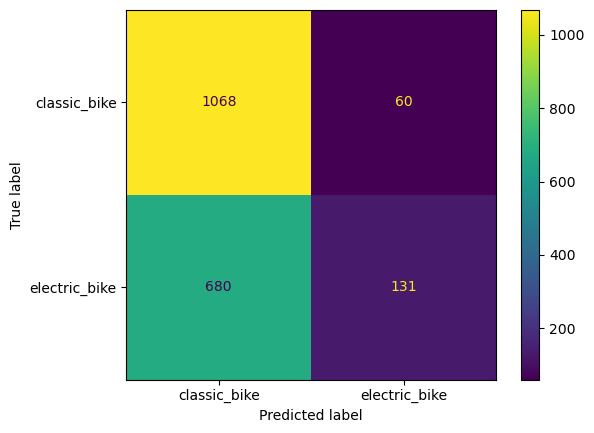

In [84]:
lda2 = LinearDiscriminantAnalysis(shrinkage=None, priors= [0.6,0.4], solver='lsqr')
lda_pipe2 = ImbPipeline([('transformer', transformer),
                       ('smote', smt), ('model', lda2)])
lda_pipe2.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(lda_pipe2, X_test, y_test)

In [85]:
print(f'Train Score: {lda_pipe2.score(X_train, y_train)}')
print(f'Test Score: {lda_pipe2.score(X_test, y_test)}')

y_pred = lda_pipe2.predict(X_test)

precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision Score: {precision}")

cv_scores = cross_val_score(
    lda_pipe2, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")

classification = classification_report(y_test, y_pred)
print(f"Classification Report:\n{classification}")

Train Score: 0.6233230134158927
Test Score: 0.6183599793708097
Precision Score: 0.6423030084808433
Cross-Validation Scores: [0.62282398 0.62346873 0.62129032 0.62258065 0.61870968]
Mean Cross-Validation Accuracy: 0.6217746719078222
Classification Report:
               precision    recall  f1-score   support

 classic_bike       0.61      0.95      0.74      1128
electric_bike       0.69      0.16      0.26       811

     accuracy                           0.62      1939
    macro avg       0.65      0.55      0.50      1939
 weighted avg       0.64      0.62      0.54      1939



The LDA model did a very good job of correctly identifying classic_bikes, but did a pretty horrible job of identifying electric bikes. This suggests that the linear boundaries LDA relied on were not sufficient to separate the two classes effectively, which is supported by my findings in our EDA at the beginning of this project. The overlap in feature distributions likely made it difficult for the model to maximize class separation. This indicates the features that influence bike type may have more complex or nonlinear interactions, where LDA is not the best to use.

## Next Steps & Discussion

#### Summary of Findings

In this analysis of CitiBike data to predict bike type chosen, the models I constructed and tested demonstrated varying levels of accuracy in predicting bike type, with overall low accuracy. The models ranked in terms of performance are as follows: Random Forest Classifier, Decision Tree Classifier, K-Nearest Neighbors, Logistic Regression, and Linear Discriminant Analysis.

Key Findings:
1) Success of Random Forest Model: The Random Forest model was the most effective, with the highest accuracy and a more balanced performance between classes as compared to other models. This model reduced overfitting and captured more complex patterns, making it better at distinguishing between classic and electric bikes.
2) Important Features: Across all models, the distance (ride_miles) and duration (ride_minutes) of rides were the most important predictors of bike type. Other features like membership type and time of day had minimal influence on predictions.
3) Challenges with Linear Models: The Logistic Regression and LDA models performed worse due to their reliance on linear relationships between variables. This led to weak separation between classes, especially when classifying electric bikes. These models highlighted the need for more complex models that could capture non-linear relationships in the data.
4) Trade-Offs in Model Performance: While the Decision Tree and KNN models showed improved accuracy compared to linear models, KNN still misclassified a significant number of electric bike rides and Decision Tree perfomed better with electric bikes but at the expense of worse accuracy with classic bikes. The Decision Tree's constrained depth and KNN's reliance on local proximity limited their ability to fully capture the complexities.

Conclusion:
The Random Forest model proved to be the most accurate among the models tested, but its precision score of 0.66 highlights significant room for improvement. The relatively low accuracy suggests that the features in the dataset may not fully capture the relationships influencing bike type. We need further data exploration or additional features to better model the underlying patterns. These findings emphasize the limitations of the current dataset CitiBike provides, and gives us a starting point for future predictions.

#### Next Steps/Improvements


To make the predictive capabilities of the models better and gain deeper insights into bike type prediction for CitiBike, I would want to incorporate these additional features into my models:

- Weather Data:
    - Including weather conditions during the rides, such as temperature, precipitation, and wind speed, could provide valuable insights into how external factors influence bike type usage. For example, there may be a greater preference for electric bikes on cold or rainy days.
- User Demographics:
    - Data on user demographics, such as age, gender, or residential neighborhood, could help us find patterns in preferences based on user characteristics. This could reveal how different user groups may have varying CitiBike preferences.
- Traffic and Infrastructure:
    - Data on traffic and proximity to subway stations or bus stops could point to external factors that may influence the type of bike chosen.
- Station-Specific Data:
    - Information about if the bike was picked up at a station that is more often a corporate hub versus residential area or tourist location may provide insight into which bike chosen. For example, if picked up from residential area and dropped at a corporate hub, that rider was potentially on the way to work and may pick an electric bike out of convenience.

By incorporating some additional features into the analysis, the models could capture a broader range of potentially more important factors that influence bike type usage, leading to better accuracy and more actionable insights for CitiBike and other bike ridesharers.